In [1]:
import numpy as np
import matplotlib.pyplot as plt

O orientation_map abaixo foi criado utilizando-se o py4dstem, através dos scripts 3 e 4 em '/home/ABTLUS/rodrigo.souza/4DSTEM/notebooks/hrtem'

In [2]:
#Loading and reshaping orientations
orientation_map = np.load('/home/rodrigo.souza/Documents/HRTEM/notebooks/orientation_map.npy', allow_pickle=True)
print(orientation_map.shape)
orientation_map_reshaped = orientation_map.reshape(-1,1,3,3)
print(orientation_map_reshaped.shape)
orientations = orientation_map_reshaped[:,0,:,2]
print(orientations.shape)

(115, 115, 1, 3, 3)
(13225, 1, 3, 3)
(13225, 3)


In [3]:
# Loading and reshaping correlations
orientation_map_corr = np.load('/home/rodrigo.souza/Documents/HRTEM/notebooks/orientation_map_corr.npy')
print(orientation_map_corr.shape)
orientation_map_corr = orientation_map_corr.reshape(-1,1)
orientation_map_corr = orientation_map_corr[:,0]
print(orientation_map_corr.shape)

(115, 115, 1)
(13225,)


(array([455.,  24.,  74., 155., 240., 389., 390., 503., 607., 629., 661.,
        632., 638., 633., 647., 639., 688., 653., 664., 590., 501., 457.,
        399., 335., 328., 266., 194., 166., 130., 100., 102.,  74.,  62.,
         51.,  48.,  23.,  21.,  11.,  10.,  12.,   9.,   8.,   2.,   1.,
          2.,   1.,   0.,   0.,   0.,   1.]),
 array([0.        , 0.14429172, 0.28858344, 0.43287516, 0.57716688,
        0.7214586 , 0.86575032, 1.01004204, 1.15433376, 1.29862548,
        1.4429172 , 1.58720892, 1.73150064, 1.87579236, 2.02008408,
        2.1643758 , 2.30866752, 2.45295924, 2.59725096, 2.74154268,
        2.8858344 , 3.03012612, 3.17441784, 3.31870957, 3.46300129,
        3.60729301, 3.75158473, 3.89587645, 4.04016817, 4.18445989,
        4.32875161, 4.47304333, 4.61733505, 4.76162677, 4.90591849,
        5.05021021, 5.19450193, 5.33879365, 5.48308537, 5.62737709,
        5.77166881, 5.91596053, 6.06025225, 6.20454397, 6.34883569,
        6.49312741, 6.63741913, 6.78171085, 6.

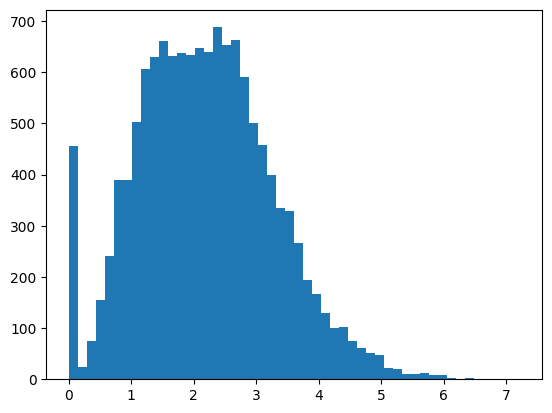

In [245]:
# Checking orientations correlation distribution
plt.hist(orientation_map_corr, bins = 50)

In [4]:
# Zeroing orientations where corr < thresh
thresh = 1
print('# of orientations:', orientations.shape[0])
print('orientations non [0,0,0]:', np.sum(np.any(orientations != [0,0,0], axis=1)))
orientations[np.where(orientation_map_corr < thresh)] = [0,0,0]
print('orientations non [0,0,0]:', np.sum(np.any(orientations != [0,0,0], axis=1)))

# of orientations: 13225
orientations non [0,0,0]: 12786
orientations non [0,0,0]: 11528


# Visualizing the data

In [5]:
data = orientations.copy()
from mpl_toolkits.mplot3d import Axes3D

Text(0.5, 1.0, 'Y Projection')

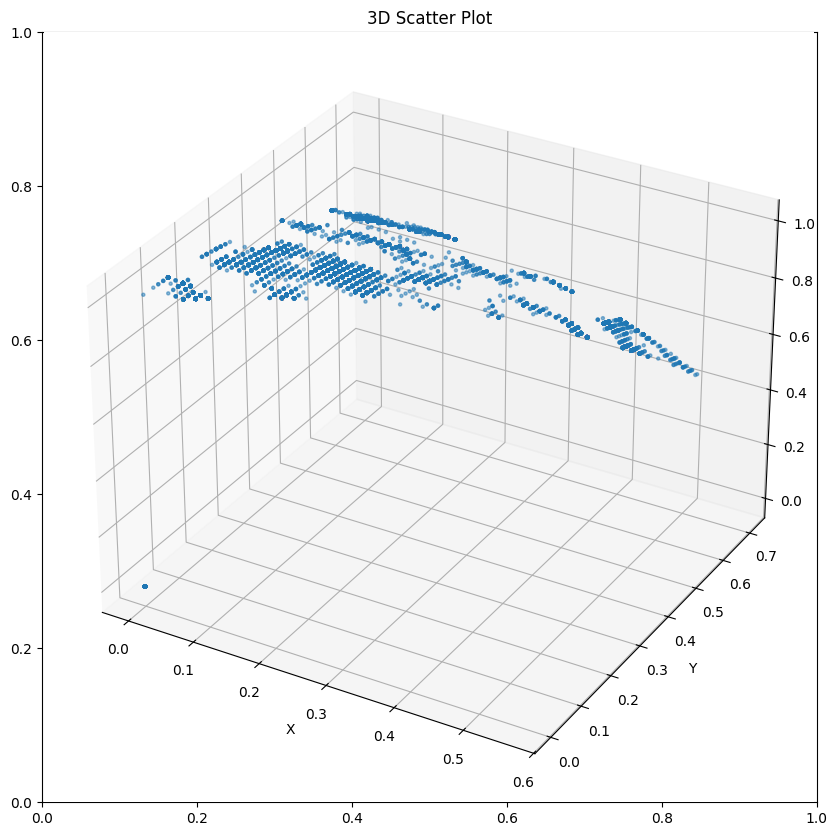

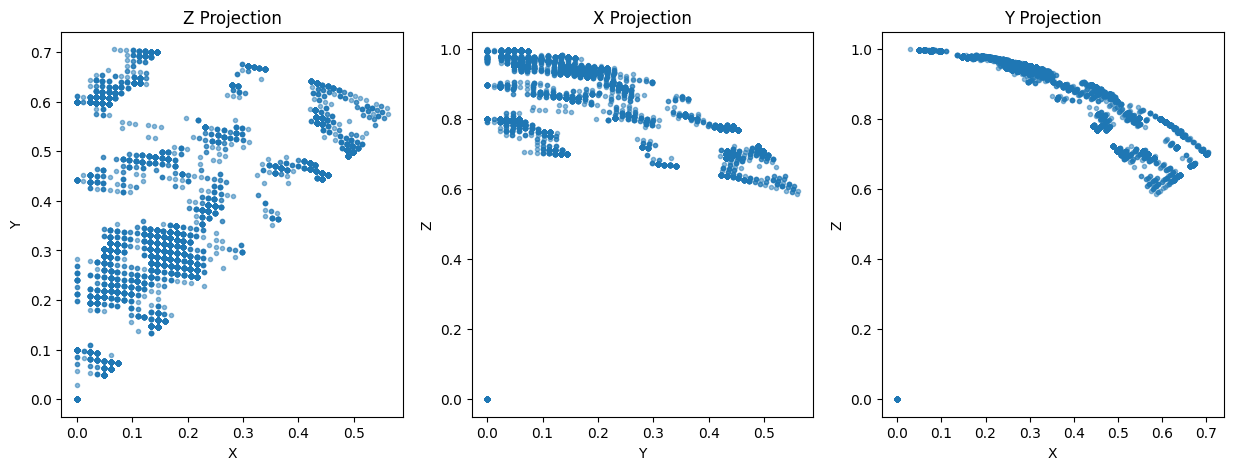

In [254]:
fig, ax = plt.subplots(figsize=(10, 10))

# 1. 3D Scatter Plot
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data[:, 0], data[:, 1], data[:, 2], marker='.', alpha=0.5)
ax.set_xlabel('X')
ax.set_ylabel('Y')
# ax.set_zlabel('Z')
ax.set_title('3D Scatter Plot')


fig, axs = plt.subplots(1, 3, figsize=(15, 5))
# 2. Z Projection
ax = axs[0]
ax.scatter(data[:, 0], data[:, 1], marker='.', alpha=0.5)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Z Projection')

# 3. X Projection
ax = axs[1]
ax.scatter(data[:, 0], data[:, 2], marker='.', alpha=0.5)
ax.set_xlabel('Y')
ax.set_ylabel('Z')
ax.set_title('X Projection')

# 4. X Projection
ax = axs[2]
ax.scatter(data[:, 1], data[:, 2], marker='.', alpha=0.5)
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_title('Y Projection')

# Clustering

In [6]:
from sklearn.cluster import DBSCAN

In [7]:
# Quanto menor eps, mais amostras ficarão na label -1 (outlier)
eps = 0.012  # Max distance between two samples for one to be considered as in the neighborhood of the other.
min_samples = 50   # The number of samples in a neighborhood for a point to be considered as a core point.
scan = DBSCAN(eps = eps, min_samples = min_samples,
                ).fit(orientations)
labels = scan.labels_
unique_labels, counts = np.unique(labels, return_counts=True)
print('number of clusters:', len(unique_labels))

number of clusters: 62


In [8]:
# Checking results of cluster. Poderia ser tanto variância das ffts, quanto das orientações?

# Intra-class variance: variance of vectors within each cluster
def calculate_intra_var(data, unique_labels):
    intra_vars = []
    for label in unique_labels:
        if label != -1:
            cluster_data = data[labels == label]
            var = np.mean(np.var(cluster_data, axis=0))
            intra_vars.append(var)
    return np.mean(intra_vars)
intra_var = calculate_intra_var(data, unique_labels)
print(f'Intra-class variance: {intra_var}')

# Inter-class variance: variance of the cluster centroids from the overall mean of the data
def calculate_inter_var(data, unique_labels):
    overall_mean = np.mean(data, axis=0)
    centroids = []
    for label in unique_labels:
        if label != -1:
            centroids.append(np.mean(data[labels == label], axis=0))

    inter_var = np.mean(np.var(centroids - overall_mean, axis=0))
    return inter_var 

inter_var = calculate_inter_var(data, unique_labels)
print(f'Inter-class variance: {inter_var:.6f}')
print('---')
print('score (smaller is better) = ', intra_var / inter_var)
# print('sub =', inter_var-intra_var)
# print('ratio =', inter_var / intra_var)
# print('harmonic mean =', (inter_var*intra_var)/(inter_var+intra_var))

Intra-class variance: 1.190028639745869e-05
Inter-class variance: 0.023454
---
score (smaller is better) =  0.0005073965116175814


## (Optional) Algorithm for DBSCAN optimization
Não parece ter certo ou errado. Quanto mais fino for meu cluster, maior o número de cluster e mais alinhados serão as orientações (idealmente).

### Option 1: Grid search

Best params: (0.004, 10.0)


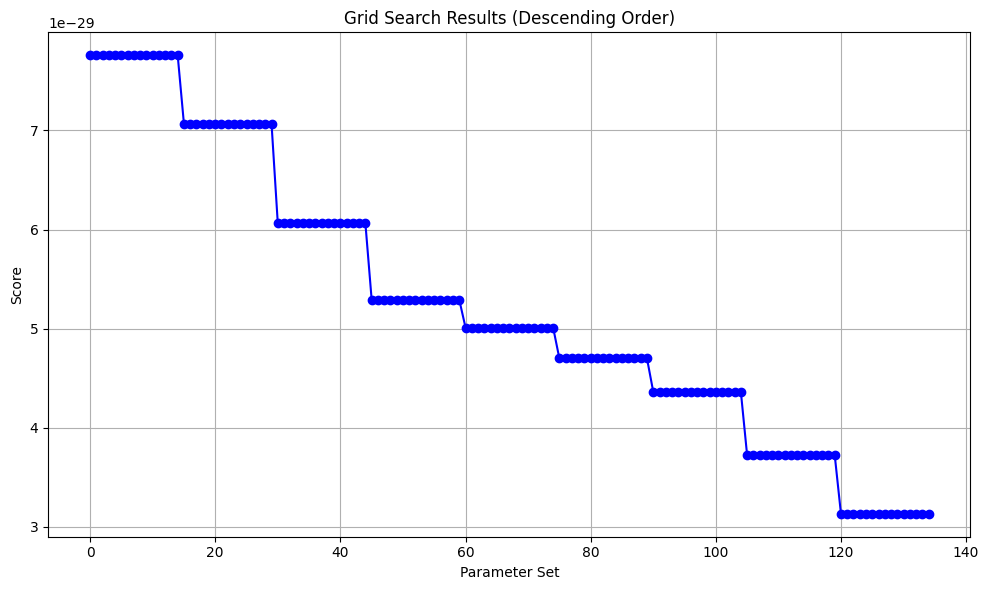

In [472]:
def objective_function(eps, min_samples):
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(data)
    labels = db.labels_
    unique_labels, counts = np.unique(labels, return_counts=True)
    intra_var = calculate_intra_var(data, unique_labels)
    inter_var = calculate_inter_var(data, unique_labels)
    score = intra_var / inter_var
    return score

eps_values = np.linspace(0.004, 0.010, 15)
min_samples_values = np.linspace(10, 50, 9)

scores = []
params = []

for eps in eps_values:
    for min_samples in min_samples_values:
        score = objective_function(eps, int(min_samples))
        scores.append(score)
        params.append((eps, min_samples))

# Sort the scores and parameters based on the score
sorted_indices = np.argsort(scores)[::-1]  # Descending order
sorted_scores = [scores[i] for i in sorted_indices]
sorted_parameters = [params[i] for i in sorted_indices]

print(f"Best params: {sorted_parameters[-1]}")

# Plot the sorted scores
plt.figure(figsize=(10, 6))
plt.plot(sorted_scores, 'bo-')
plt.xlabel('Parameter Set')
plt.ylabel('Score')
plt.title('Grid Search Results (Descending Order)')
# plt.xticks(range(len(sorted_scores)), [f'{params}' for params in sorted_parameters], rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()

In [474]:
print(sorted_parameters[-5:])
print(sorted_scores[-5:])

[(0.008285714285714285, 10.0), (0.009142857142857144, 10.0), (0.005285714285714286, 10.0), (0.005714285714285714, 10.0), (0.004, 10.0)]
[3.131710638319762e-29, 3.131710638319762e-29, 3.131710638319762e-29, 3.131710638319762e-29, 3.131710638319762e-29]


## Ploting cluster results

In [9]:
# # Printing # of elements
# eps = sorted_parameters[-1][0]  # Max distance between two samples for one to be considered as in the neighborhood of the other.
# min_samples = int(sorted_parameters[-1][1])  # The number of samples in a neighborhood for a point to be considered as a core point.
# scan = DBSCAN(eps = eps, min_samples = min_samples,
#                 ).fit(orientations)
# labels = scan.labels_
# unique_labels, counts = np.unique(labels, return_counts=True)

# Print labels and # of elements
for label, count in zip(unique_labels, counts):
    print(f'Label {label}: {count} elements')

Label -1: 3456 elements
Label 0: 56 elements
Label 1: 1697 elements
Label 2: 87 elements
Label 3: 74 elements
Label 4: 86 elements
Label 5: 452 elements
Label 6: 62 elements
Label 7: 62 elements
Label 8: 281 elements
Label 9: 273 elements
Label 10: 182 elements
Label 11: 98 elements
Label 12: 99 elements
Label 13: 142 elements
Label 14: 73 elements
Label 15: 381 elements
Label 16: 510 elements
Label 17: 261 elements
Label 18: 108 elements
Label 19: 116 elements
Label 20: 180 elements
Label 21: 185 elements
Label 22: 67 elements
Label 23: 72 elements
Label 24: 63 elements
Label 25: 91 elements
Label 26: 480 elements
Label 27: 173 elements
Label 28: 118 elements
Label 29: 196 elements
Label 30: 75 elements
Label 31: 104 elements
Label 32: 94 elements
Label 33: 60 elements
Label 34: 74 elements
Label 35: 473 elements
Label 36: 197 elements
Label 37: 89 elements
Label 38: 70 elements
Label 39: 80 elements
Label 40: 77 elements
Label 41: 52 elements
Label 42: 57 elements
Label 43: 126 eleme

Label -1: 67 elements
Label 0: 881 elements
Label 1: 1167 elements
Label 2: 5697 elements
Label 3: 1697 elements
Label 4: 1438 elements
Label 5: 678 elements
Label 6: 69 elements
Label 7: 183 elements
Label 8: 37 elements
Label 9: 427 elements
Label 10: 542 elements
Label 11: 129 elements
Label 12: 128 elements
Label 13: 24 elements
Label 14: 44 elements
Label 15: 17 elements


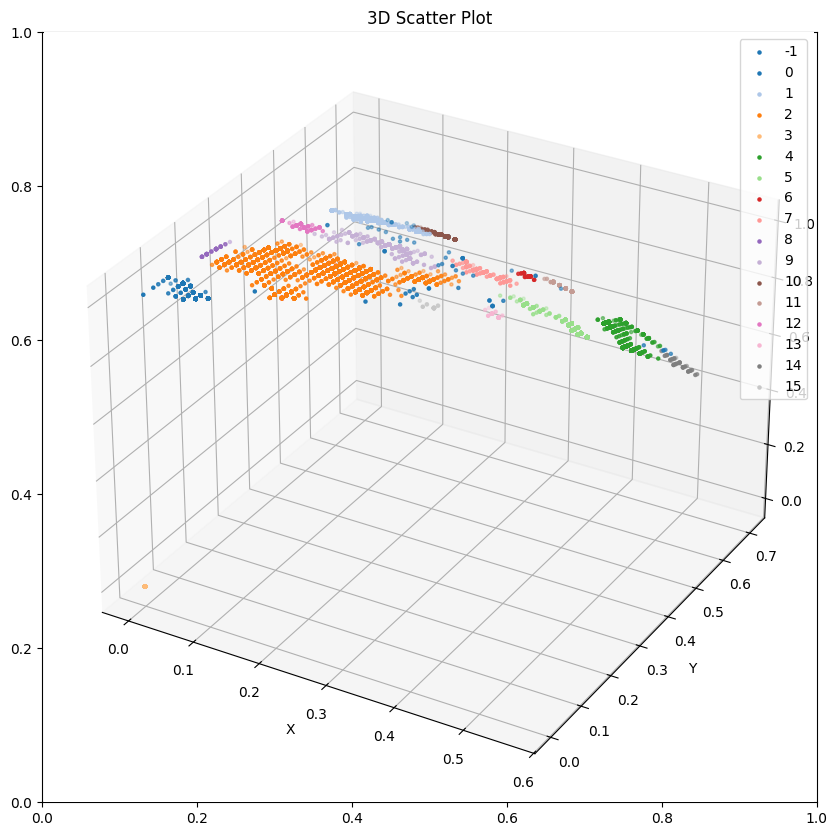

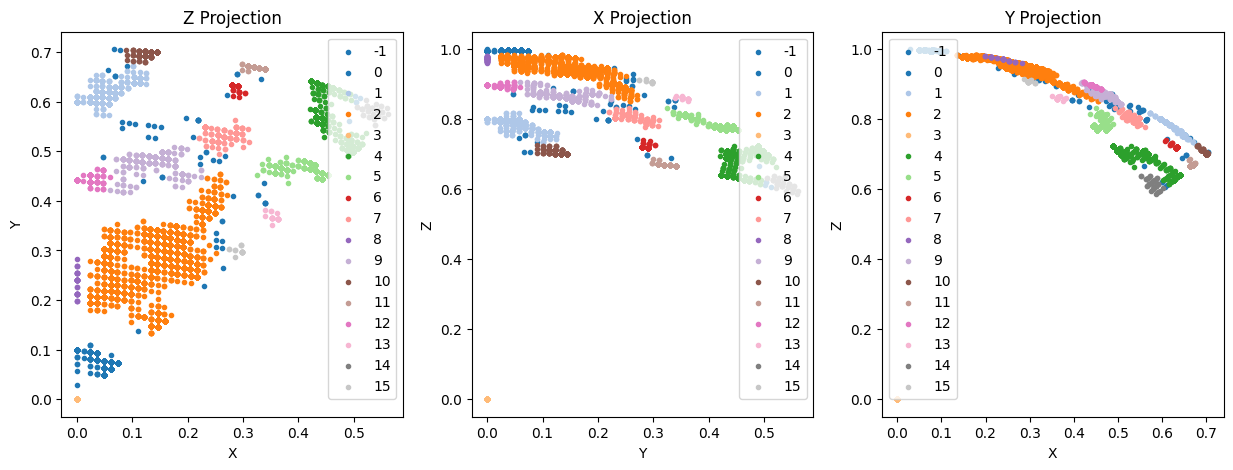

In [411]:
# Plotting (optional, if number of classes < 20)
fig, ax = plt.subplots(figsize=(10, 10))
colormap = plt.get_cmap('tab20')
alpha = 0.5

# 1. 3D Scatter Plot
ax = fig.add_subplot(111, projection='3d')
for label in np.unique(labels):
    mask = labels == label
    ax.scatter(data[mask, 0], data[mask, 1], data[mask, 2], c = [colormap(label)], marker='.', label=f'{label}')
ax.set_xlabel('X')
ax.set_ylabel('Y')
# ax.set_zlabel('Z')
ax.set_title('3D Scatter Plot')
ax.legend()


fig, axs = plt.subplots(1, 3, figsize=(15, 5))
# 2. Z Projection
ax = axs[0]
for label in np.unique(labels):
    mask = labels == label
    ax.scatter(data[mask, 0], data[mask, 1], c = [colormap(label)], marker='.', label=f'{label}')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Z Projection')
ax.legend()
# 3. X Projection
ax = axs[1]
for label in np.unique(labels):
    mask = labels == label
    ax.scatter(data[mask, 0], data[mask, 2], c = [colormap(label)], marker='.', label=f'{label}')
ax.set_xlabel('Y')
ax.set_ylabel('Z')
ax.set_title('X Projection')
ax.legend()
# 4. X Projection
ax = axs[2]
for label in np.unique(labels):
    mask = labels == label
    ax.scatter(data[mask, 1], data[mask, 2], c = [colormap(label)], marker='.', label=f'{label}')
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_title('Y Projection')
ax.legend()

## Checking ffts from labels

In [10]:
import hyperspy.api as hs
# braggpeaks = np.load('/home/ABTLUS/rodrigo.souza/HRTEM/notebooks/braggpeaks.npy', allow_pickle = True)
s = hs.load('/home/rodrigo.souza/Documents/HRTEM/notebooks/ffts_circular_rs2_SVD.hspy')
ffts = s.data
ffts.shape

WARNING | Hyperspy | Numba is not installed, falling back to non-accelerated implementation. (hyperspy.decorators:254)
WARNING | Hyperspy | Numba is not installed, falling back to non-accelerated implementation. (hyperspy.decorators:254)
WARNING | Hyperspy | Numba is not installed, falling back to non-accelerated implementation. (hyperspy.decorators:254)
WARNING | Hyperspy | Numba is not installed, falling back to non-accelerated implementation. (hyperspy.decorators:254)
WARNING | Hyperspy | Numba is not installed, falling back to non-accelerated implementation. (hyperspy.decorators:254)
WARNING | Hyperspy | Numba is not installed, falling back to non-accelerated implementation. (hyperspy.decorators:254)
WARNING | Hyperspy | Numba is not installed, falling back to non-accelerated implementation. (hyperspy.decorators:254)
WARNING | Hyperspy | Numba is not installed, falling back to non-accelerated implementation. (hyperspy.decorators:254)
WARNING | Hyperspy | Numba is not installed, fal

(13248, 220, 220)

In [ ]:
# Checking orientations
selected_label = 1
selected_label_indices = np.where(labels == selected_label)
it = 0
for i in range(1000): # Only 15 elements
    index = selected_label_indices[0][i]
    print('Element', it, orientations[index])
    it+=1

# Now, checking ffts (15samples)
fig, ax = plt.subplots(3,5, figsize = (25,15))
ax = ax.flatten()
for i in range(15):
    index = selected_label_indices[0][i]
    ax[i].imshow(np.log(ffts[index]))
    orientation = orientations[index]
    orientation_str = f'({orientation[0]:.5f}, {orientation[1]:.5f}, {orientation[2]:.5f})'
    ax[i].set_title(f'{orientation_str}, {orientation_map_corr[index]:.5f}')
    # ax[i].scatter([element[0] for element in braggpeaks[0]], [element[1] for element in braggpeaks[0]], c='r')
    fig.suptitle('Label ' + str(selected_label))

In [89]:
np.save('/home/rodrigo.souza/Documents/HRTEM/notebooks/labels.npy', labels)

: 